# Learned representation-guided diffusion models for large-image generation
Reproduction Point:  25

# Introduction 

The reliance on fine-grained annotations, which are resource-intensive and often impractical to gather, makes it difficult to generate large-scale, high-quality images in disciplines such as satellite imagery and histopathology . Existing diffusion models need a lot of labeled data and struggle to preserve semantic consistency over larger images, even though they work well for smaller images. The challenge addressed by the paper is to enable efficient, annotation-free, large-image synthesis while maintaining semantic and spatial consistency across the generated images.

The paper presents a novel method to produce high-quality, large-scale images. Traditional diffusion models usually require fine-grained annotations, for which topic expertise is needed and are often resource intensive. To overcome this, the research proposes to use self-supervised learning (SSL) embeddings instead of human annotations. The synthesis of semantically rich and spatially consistent images is made possible by these embeddings, which serve as efficient conditioning signals for diffusion model training. Additionally, a new paradigm for text-to-large-image synthesis is presented in the research, showcasing the model's adaptability and potential to influence applications in specialized domains such as remote sensing and medical imaging.

Repo: https://github.com/cvlab-stonybrook/Large-Image-Diffusion/tree/main

## Concepts Involved:
The core idea revolves around leveraging self-supervised learning representations as a replacement for fine-grained labels, allowing diffusion models to generate large images through patch-based synthesis. The paper suggests training patch-level diffusion models conditioned on SSL embeddings, capturing local semantics while preserving the global spatial arrangement through a grid of embeddings. By interpolating and fusing SSL features, the model ensures semantic consistency and long-range dependencies across patches. Furthermore, the authors demonstrate the system's adaptability by enabling text-to-large-image generation, where text captions guide the arrangement of SSL embeddings to synthesize domain-specific large-scale images.

# Steps involved:
1) Environment and directory setup
2) Download of WSI dataset (Large-scale input images), Pre-trained Models and config files
3) Generation of Patch level Dataset
4) SSL Embedding generations for Patch level datasets
5) Image generation using Pre-trained models
6) FID Calculation using pytorch_fid

## Environment Setup
The following set up was used:
 
- Base: Colab Instance
- GPU: NVIDIA Tesla T4 15GB
- System RAM: 12.7 GB
- Disk Storage: 112.6 GB (expandable via Google Drive)
- Software Stack: CUDA 12.2, Python 3.8.5, Jupyter Notebook

## Notes
- "condacolab" is used to generate conda environemts according to the specification in the project as colab does not directly allow conda usage

Before creating env:
1) Change clip=1.0 to clip=0.1.0 in /content/Large-Image-Diffusion/environment.yaml\
2) Install taming-transformers-rom1504 and pytorch-fid

In [ ]:
# Setting up Conda Env on Colab
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Cloning the Large-Image-Diffusion repository
!git clone https://github.com/cvlab-stonybrook/Large-Image-Diffusion.git

Cloning into 'Large-Image-Diffusion'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 116 (delta 8), reused 10 (delta 3), pack-reused 94 (from 1)
Receiving objects: 100% (116/116), 54.43 MiB | 32.52 MiB/s, done.
Resolving deltas: 100% (14/14), done.


#### Creating a conda env 'sd' in colab os

In [ ]:
# Creating the Conda env based on the YAML file provided
!conda env create -f /content/Large-Image-Diffusion/environment.yaml

Channels:
 - pytorch
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



cudatoolkit-11.3.1   | 549.3 MB  | :   0% 0/1 [00:00<?, ?it/s]
mkl-2021.4.0         | 142.6 MB  | :   0% 0/1 [00:00<?, ?it/s]

pytorch-1.12.1       | 60.8 MB   | :   0% 0/1 [00:00<?, ?it/s]


python-3.8.5         | 49.3 MB   | :   0% 0/1 [00:00<?, ?it/s]



torchvision-0.13.1   | 28.7 MB   | :   0% 0/1 [00:00<?, ?it/s]




icu-58.2             | 22.6 MB   | :   0% 0/1 [00:00<?, ?it/s]





boost-cpp-1.70.0     | 21.1 MB   | :   0% 0/1 [00:00<?, ?it/s]






poppler-21.03.0      | 15.9 MB   | :   0% 0/1 [00:00<?, ?it/s]







libgdal-3.6.2        | 10.6 MB   | :   0% 0/1 [00:00<?, ?it/s]








proj-6.2.1           | 10.2 MB   | :   0% 0/1 [00:00<?, ?it/s]









ffmpeg-4.3           | 9.9 MB   

In [ ]:
# Installations needed not mentioned in the YAML
!source activate sd && pip install taming-transformers-rom1504 pytorch-fid

     |████████████████████████████████| 51 kB 286 kB/s 


In [ ]:
# Check for Virtual Env python version
!source activate sd && python --version

Python 3.8.5


In [ ]:
!python --version

Python 3.11.11


## Directory Setup

To set up the directory, the following steps are needed:\
1) Download pretrained models:
- BRCA 20x (https://drive.google.com/drive/folders/1kZ69wVEHV3k3Zr1hgS3kftz9cfNb9BxA?usp=sharing),
- CRC(https://drive.google.com/drive/folders/1r1Kgcgy34rP3O-X4AqhQ09Sf1OZdHvm2?usp=sharing),
- NAIP (https://drive.google.com/drive/folders/1mWy5wi-Tcpcb8-0n6eczzyjBoMAdK9fA?usp=sharing),
- BRCA 5x(https://drive.google.com/drive/folders/1NL0mpepFzYfrb4tH4NVzAYAWkirMSBuB?usp=sharing)
2) Download datasets:\
- TCGA-BRCA, TCGA-CRC : Can be downloaded from https://portal.gdc.cancer.gov/
- NAIP: can be downloaded from https://lila.science/datasets/chesapeakelandcover

In [ ]:
# Library to download data from Gdrive
!pip3 install gdown

In [ ]:
!mkdir /content/Large-Image-Diffusion/logs

## Downloading Checkpoints and configs
Download the checkpoints and config files and place them as per the following directory structure

logs/\
├── brca_hipt_20x/\
├────  checkpoints/\
├──── configs/\
├── brca_ctranspath_5x/\
├──── checkpoints/\
├──── configs/\
├── crc_ibot_20x/\
├──── checkpoints/\
├──── configs/\
├── naip_idm/\
├──── checkpoints/\
├──── configs/

In [ ]:
# brca_hipt_20x
!gdown https://drive.google.com/uc?id=1KMN5amIW9894VkXymTJzbkqZrCfWslSh

!mkdir /content/Large-Image-Diffusion/logs/brca_hipt_20x
!mkdir /content/Large-Image-Diffusion/logs/brca_hipt_20x/checkpoints
!mv /content/last.ckpt /content/Large-Image-Diffusion/logs/brca_hipt_20x/checkpoints

# brca_hipt_20x Config
!gdown https://drive.google.com/uc?id=1X7_F584zu1BlNBUUavYxcbpTOSw18lyP
!mkdir /content/Large-Image-Diffusion/logs/brca_hipt_20x/configs
!mv /content/10-01T01-26-project.yaml /content/Large-Image-Diffusion/logs/brca_hipt_20x/configs/


Downloading...
From (original): https://drive.google.com/uc?id=1KMN5amIW9894VkXymTJzbkqZrCfWslSh
From (redirected): https://drive.google.com/uc?id=1KMN5amIW9894VkXymTJzbkqZrCfWslSh&confirm=t&uuid=46cdbc77-366a-47c9-929b-246c592e8d24
To: /content/last.ckpt
100% 1.92G/1.92G [00:22<00:00, 86.4MB/s]
mkdir: cannot create directory ‘/content/Large-Image-Diffusion/logs/brca_hipt_20x’: File exists
mkdir: cannot create directory ‘/content/Large-Image-Diffusion/logs/brca_hipt_20x/checkpoints’: File exists
Downloading...
From: https://drive.google.com/uc?id=1X7_F584zu1BlNBUUavYxcbpTOSw18lyP
To: /content/10-01T01-26-project.yaml
100% 2.62k/2.62k [00:00<00:00, 13.1MB/s]
mkdir: cannot create directory ‘/content/Large-Image-Diffusion/logs/brca_hipt_20x/configs’: File exists


In [ ]:
# brca_ctranspath_5x
!gdown https://drive.google.com/uc?id=1Mv9Loey0fS8FF6-ZukkZ4Ie1TfAqGt9t

!mkdir /content/Large-Image-Diffusion/logs/brca_ctranspath_5x
!mkdir /content/Large-Image-Diffusion/logs/brca_ctranspath_5x/checkpoints
!mv /content/last.ckpt /content/Large-Image-Diffusion/logs/brca_ctranspath_5x/checkpoints

# brca_ctranspath_5x Config
!gdown https://drive.google.com/uc?id=1KB3UuXlRwf-8M1wGhvVfQgcRpdyNdHiR
!mkdir /content/Large-Image-Diffusion/logs/brca_ctranspath_5x/configs
!mv /content/10-08T21-49-project.yaml /content/Large-Image-Diffusion/logs/brca_ctranspath_5x/configs/

Downloading...
From (original): https://drive.google.com/uc?id=1Mv9Loey0fS8FF6-ZukkZ4Ie1TfAqGt9t
From (redirected): https://drive.google.com/uc?id=1Mv9Loey0fS8FF6-ZukkZ4Ie1TfAqGt9t&confirm=t&uuid=bf18f991-6243-4f59-b8e6-5d3129902a24
To: /content/last.ckpt
100% 2.63G/2.63G [00:37<00:00, 69.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KB3UuXlRwf-8M1wGhvVfQgcRpdyNdHiR
To: /content/10-08T21-49-project.yaml
100% 2.38k/2.38k [00:00<00:00, 11.7MB/s]


In [ ]:
# crc_ibot_20x
!gdown https://drive.google.com/uc?id=1sWLnwuk0iBTp7tvPTmr_4HU6iv-MLJrj

!mkdir /content/Large-Image-Diffusion/logs/crc_ibot_20x
!mkdir /content/Large-Image-Diffusion/logs/crc_ibot_20x/checkpoints
!mv /content/last.ckpt /content/Large-Image-Diffusion/logs/crc_ibot_20x/checkpoints

# crc_ibot_20x Config
!gdown https://drive.google.com/uc?id=1ryR1S3BNQTuiHq3GJZusx3Ja_Bi4Ak0B
!mkdir /content/Large-Image-Diffusion/logs/crc_ibot_20x/configs
!mv /content/10-15T17-07-project.yaml /content/Large-Image-Diffusion/logs/crc_ibot_20x/configs/


Downloading...
From (original): https://drive.google.com/uc?id=1sWLnwuk0iBTp7tvPTmr_4HU6iv-MLJrj
From (redirected): https://drive.google.com/uc?id=1sWLnwuk0iBTp7tvPTmr_4HU6iv-MLJrj&confirm=t&uuid=972e94d0-d60f-4a3c-8d44-e4444551587c
To: /content/last.ckpt
100% 2.63G/2.63G [00:22<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ryR1S3BNQTuiHq3GJZusx3Ja_Bi4Ak0B
To: /content/10-15T17-07-project.yaml
100% 2.40k/2.40k [00:00<00:00, 11.9MB/s]


In [ ]:
# naip_idm
!gdown https://drive.google.com/uc?id=1NyXTHdf2qbZxFFar7gno-FM151JDWxig

!mkdir /content/Large-Image-Diffusion/logs/naip_idm
!mkdir /content/Large-Image-Diffusion/logs/naip_idm/checkpoints
!mv /content/last.ckpt /content/Large-Image-Diffusion/logs/naip_idm/checkpoints

# naip_idm Config
!gdown https://drive.google.com/uc?id=18QmT86pXdNnvf0ydtt9Q6jUXSik_0ORG
!mkdir /content/Large-Image-Diffusion/logs/naip_idm/configs
!mv /content/10-25T16-23-project.yaml /content/Large-Image-Diffusion/logs/naip_idm/configs/


## Patch Data Generation using dsmil-wsi
The paper proposes creating a patch-level dataset from large Whole Slide Images (WSIs) using the dsmil-wsi repository (https://github.com/binli123/dsmil-wsi). This involves extracting smaller image patches from WSIs at different magnifications, making them suitable for diffusion models.
The configurations follow:
- Base Magnification of 20 for crc_x20 and brca_x20 datasets
- Base magnification of 5 for brca_x5 dataset

Note: 
- NAIP dataset 256 * 256 patches were generated separately using rasterio as WSI files were unavailable.

In [ ]:
# Executed in a separate notebook so that the environments do not conflict
!pip install numpy pillow matplotlib scikit-learn pyyaml pandas scikit-image opencv-python tqdm openslide-python openslide-bin
!git clone https://github.com/binli123/dsmil-wsi.git
%cd /content/dsmil-wsi

# TGCA-CRC Dataset
!tar -xvzf /content/gdc_download_20250120_174609.134195.tar.gz -C /content/dsmil-wsi/WSI/crc
!python /content/dsmil-wsi/deepzoom_tiler.py -m 0 -b 20 -d crc -q 90 -s 512

#TGCA-BRCA dataset
!python /content/dsmil-wsi/deepzoom_tiler.py -m 0 -b 20 -d brca -q 90 -s 256

#BRCA5x dataset
!python /content/dsmil-wsi/deepzoom_tiler.py -m 0 -b 5 -d brca -q 90 -s 256


#### NAIP Patch generation custom script
This script extracts 256x256 pixel patches from NAIP aerial imagery in the Chesapeake Land Cover dataset. The patches are saved as PNGs for further processing or analysis.

In [ ]:
# NAIP Dataset
!apt-get install -q -y google-cloud-sdk rasterio
!gsutil ls gs://public-datasets-lila/lcmcvpr2019/cvpr_chesapeake_landcover/md_1m_2013_extended-debuffered-test_tiles/ # Generates list of values available under the directory
!gsutil cp gs://public-datasets-lila/lcmcvpr2019/cvpr_chesapeake_landcover/md_1m_2013_extended-debuffered-test_tiles/m_3807502_se_18_1_naip-new.tif /content/chesapeake_test_data/

# NAIP Patch Generation
# 256 * 256 patches generated
import os
import numpy as np
import rasterio
from rasterio.windows import Window

def save_patch(array, output_path, driver="PNG"):
    """
    Saves a patch array to disk using rasterio.
    array shape: (bands, height, width) for GeoTIFF.
    """
    height, width = array.shape[1], array.shape[2]
    count = array.shape[0]
    dtype = array.dtype

    with rasterio.open(
        output_path,
        'w',
        driver=driver,
        height=height,
        width=width,
        count=count,
        dtype=dtype,
        crs=None,
        transform=None
    ) as dst:
        dst.write(array)

def naip_extractor(image_tif, output_dir):
    patch_size = 256
    stride = 256
    save_format = "png"

    # Create output folders
    image_dir = os.path.join(output_dir, "images")
    os.makedirs(image_dir, exist_ok=True)

    # Open the main NAIP (aerial) raster
    with rasterio.open(image_tif) as src_img:
        width = src_img.width
        height = src_img.height
        crs = src_img.crs
        transform = src_img.transform
        nbands = src_img.count

        # Iterate over the raster in patch_size x patch_size windows
        patch_id = 0
        for top in range(0, height, stride):
            for left in range(0, width, stride):
                # define the Window
                window = Window(left, top, patch_size, patch_size)
                if (left + patch_size > width) or (top + patch_size > height):
                    continue

                # Read the aerial image patch
                img_patch = src_img.read(window=window, boundless=False)
                # shape is [bands, patch_size, patch_size]

                # Save the patch
                patch_name = f"patch_{patch_id}_{left}_{top}.{save_format}"
                patch_path = os.path.join(image_dir, patch_name)

                img_patch_clamped = np.clip(img_patch, 0, 255).astype(np.uint8)
                save_patch(img_patch_clamped, patch_path, driver="PNG")
                patch_id += 1

    print(f"Extraction complete. Generated {patch_id} patches.")

for file_name in os.listdir('/content/chesapeake_test_data'):
    naip_extractor(f"/content/chesapeake_test_data/{file_name}", "/content/NAIP/patch_out")

## FID generated on patch datasets without embedding
The following section tries to generate images without including SSL embeddings to check if the model requires SSL embeddings during test time or the model has internally learned the embedding generation process. The embeddings were filled as an array of 0s.

In [ ]:
%cd /content/Large-Image-Diffusion/

##### FID For BRCA20x with no Embeddings

In [ ]:
# Directly using 20x patches generated from DSMIL Repo on TCGA-BRCA Dataset
!source activate sd && python /content/Large-Image-Diffusion/test_run.py --data_path /content/Large-Image-Diffusion/data/brca_20x

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Loading model from /content/Large-Image-Diffusion/logs/brca_hipt_20x/checkpoints/last.ckpt
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up

In [ ]:
# FID Score generation using pytorch_fid library.
# FID for BRCA20x dataset with embeddings filled as an array of 0s
!source activate sd && python -m pytorch_fid real_images fake_images --device cuda:0

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: canno
nt open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
100% 2/2 [00:01<00:00,  1.73it/s]
100% 2/2 [00:00<00:00,  2.29it/s]
FID: 425.54478870375215


##### FID For CRC20x with no Embeddings

In [ ]:
# Directly using 20x patches generated from DSMIL Repo on CRC dataset
!source activate sd && python /content/Large-Image-Diffusion/test_run.py --data_path /content/Large-Image-Diffusion/data/crc

In [ ]:
# FID for CRC dataset with embeddings filled as an array of 0s
!source activate sd && python -m pytorch_fid real_images fake_images --device cuda:0

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: canno
nt open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
100% 2/2 [00:01<00:00,  1.73it/s]
100% 2/2 [00:00<00:00,  2.29it/s]
FID: 417.9338611600462


### Observation:
The high FID values highlight the need to use larger test datasets and incorporate embeddings in the test data. To proceed, embeddings are generated using HIPT for the BRCA dataset and iBOT for the CRC dataset.


# Embedding Generation
Self-Supervised Learning (SSL) Embeddings are generated to extract important features from patch-level images.
SSL models like ViTs (e.g., HIPT, iBOT, CTransPath) are used.

### HIPT for BRCA embeddings
The work uses the following repo (https://github.com/mahmoodlab/HIPT) to generate SSL Embeddings for the BRCA 20x patches
The scripts are used directly from the mentioned repo

In [ ]:
# Executed on a separate notebook to avoid environment conflict
!git clone https://github.com/mahmoodlab/HIPT.git
%cd HIPT
!pip install -r requirements.txt
!git lfs pull --include "*.pth"
!unzip /content/brca_patch.zip

In [ ]:
# Code provided in the repository, modified to generate the required pickle file
import torch
from einops import rearrange, repeat
from HIPT_4K.hipt_model_utils import get_vit256
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
def preprocess(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])
    return transform(image)
class HIPT_256(torch.nn.Module):
    """
    HIPT Model (ViT_4K-256) for encoding non-square images (with [256 x 256] patch tokens), with
    [256 x 256] patch tokens encoded via ViT_256-16 using [16 x 16] patch tokens.
    """
    def __init__(self,
        model256_path: str = '/content/HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth',
        device256='cpu'):

        super().__init__()
        self.model256 = get_vit256(pretrained_weights=model256_path).to(device256)
        self.device256 = device256

    def forward(self, path):
        """
        Forward pass of HIPT (given an image tensor x), outputting the [CLS] token from ViT_4K.
        1. x is center-cropped such that the W / H is divisible by the patch token size in ViT_4K (e.g. - 256 x 256).
        2. x then gets unfolded into a "batch" of [256 x 256] images.
        3. A pretrained ViT_256-16 model extracts the CLS token from each [256 x 256] image in the batch.
        4. These batch-of-features are then reshaped into a 2D feature grid (of width "w_256" and height "h_256".)
        5. This feature grid is then used as the input to ViT_4K-256, outputting [CLS]_4K.

        Args:
          - x (torch.Tensor): [1 x C x W' x H'] image tensor.

        Return:
          - features_cls4k (torch.Tensor): [1 x 192] cls token (d_4k = 192 by default).
        """
        all_embeddings = []
        for file_id in os.listdir(path):
          for file_name in os.listdir(os.path.join(path, file_id)):
            if file_name.endswith(('.jpg', '.jpeg')):
              img_path = os.path.join(path, file_id, file_name)
              img = Image.open(img_path).convert('RGB')
              img_tensor = preprocess(img).unsqueeze(0).to(self.device256, non_blocking=True)

              # batch_256, w_256, h_256 = self.prepare_img_tensor(x)                    # 1. [1 x 3 x W x H].
              # batch_256 = batch_256.unfold(2, 256, 256).unfold(3, 256, 256)           # 2. [1 x 3 x w_256 x h_256 x 256 x 256]
              # batch_256 = rearrange(batch_256, 'b c p1 p2 w h -> (b p1 p2) c w h')    # 2. [B x 3 x 256 x 256], where B = (1*w_256*h_256)
              features_cls256 = self.model256(img_tensor).detach().cpu()
              all_embeddings.append({
                    "image": np.array(img),
                    "feat_20x": features_cls256
                })

        return all_embeddings
val_256 = HIPT_256()
final_embeddding = val_256.forward('/content/HIPT/PatchDatasets/dsmil-wsi')

### iBot for CRC embedding Generation
The work uses the following iBoT repo (https://github.com/owkin/HistoSSLscaling) to generate SSL Embeddings for the CRC 20x patches
The scripts are used directly from the mentioned repo

In [ ]:
# Using the HistoSSLscaling Repo
!git clone https://github.com/owkin/HistoSSLscaling.git
%cd HistoSSLscaling
!pip install -r requirements.txt

!pip install gdown
# Download Pretrained Model
!gdown https://drive.google.com/uc?id=1uxsoNVhQFoIDxb4RYIiOtk044s6TTQXY

!mkdir /content/HistoSSLscaling/weights
!mv /content/ibot_vit_base_pancan.pth /content/HistoSSLscaling/weights

In [ ]:
# Code outline provided in the repository, modified to generate the required pickle file
import os
from PIL import Image
import torch
from rl_benchmarks.models import iBOTViT
from torchvision import transforms
import pickle
from tqdm import tqdm
import numpy as np

# Initialize the iBOT ViT-B PanCancer model (Phikon)
weights_path = "/content/HistoSSLscaling/weights/ibot_vit_base_pancan.pth"
model = iBOTViT(architecture="vit_base_pancan", encoder="teacher", weights_path=weights_path)

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Directory containing your images
image_dir = "/content/HistoSSLscaling/data/crc/"
output_file = "/content/HistoSSLscaling/ibot_embeddings.pkl"

# Initialize a list to store embeddings
embeddings = []

# Process each image
with torch.no_grad():
  for img_folder in tqdm(os.listdir(image_dir)):
    for img_name in os.listdir(os.path.join(image_dir, img_folder)):
      if img_name.endswith(('.jpg', '.jpeg')):
          img_path = os.path.join(image_dir, img_folder, img_name)
          image = Image.open(img_path).convert('RGB')
          tensor = transform(image).unsqueeze(0)  # Add batch dimension

          feature = model(tensor).squeeze(0).numpy()  # Extract features

          embeddings.append({
              "image": np.array(image),
              "feat_patch": feature
          })

# Save embeddings to a pickle file
with open(output_file, 'wb') as f:
    pickle.dump(embeddings, f)

print(f"Embeddings saved to {output_file}")

### CTransPath for BRCA 5x Dataset
The work uses the following CTransPath repo (https://github.com/Xiyue-Wang/TransPath) to generate SSL Embeddings for the BRCA 5x patches
The scripts writes file path, dir_id and other info into the file filenames.csv which is picked up by the get_features_CTransPath script

In [ ]:
# Using CTransPath repo for SSL Embedding gen of BRCA 5x
!git clone https://github.com/Xiyue-Wang/TransPath.git

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1JV7aj9rKqGedXY1TdDfi3dP07022hcgZ
!gdown https://drive.google.com/uc?id=1DoDx_70_TLj98gTf6YTXnu4tFhsFocDX
!pip install timm-0.5.4.tar

In [ ]:
import os
filenames = []
for dir_id in os.listdir('/content/TransPath/data/single'):
  for subfile_name in os.listdir(os.path.join('/content/TransPath/data/single', dir_id)):
    for file_name in os.listdir(os.path.join('/content/TransPath/data/single', dir_id, subfile_name)):
      if file_name.endswith(('.jpg', '.jpeg')):
        filenames.append(os.path.join('/content/TransPath/data/single', dir_id, subfile_name, file_name))
import pandas as pd
pd.DataFrame(filenames, columns=['filename']).to_csv('/content/TransPath/filenames.csv', index=False)

In [ ]:
!python get_features_CTransPath.py

#### Custom Code for Image generation build off the notebooks provided on the repo
Test_embedding.py
Used to generate the Real and Fake Image directory structure.

In [ ]:
import argparse
import torch
import torch.nn.functional as F
import numpy as np
import os
from pathlib import Path
import pickle
from einops import rearrange
from torchvision.utils import make_grid
from PIL import Image

# Make sure you have your custom imports available
# e.g., from notebooks.utils import get_model
#       from ldm.models.diffusion.plms import PLMSSampler
# Adjust the import paths as needed in your environment
from notebooks.utils import get_model
from ldm.models.diffusion.plms import PLMSSampler

def main():
    parser = argparse.ArgumentParser(description="Generate images from a diffusion model and save them.")
    parser.add_argument("--pickle_path", type=str, required=True,
                        help="Path to the pickle file containing embeddings or image info.")
    parser.add_argument("--log_dir", type=str, required=True,
                        help="Path to the log directory containing the diffusion model checkpoints.")
    parser.add_argument("--checkpoint_name", type=str, default="last.ckpt",
                        help="Name of the checkpoint file (default: last.ckpt).")
    parser.add_argument("--batch_size", type=int, default=8,
                        help="Batch size for generation (default: 8).")
    parser.add_argument("--scale", type=float, default=2.0,
                        help="Unconditional guidance scale (default: 2.0).")
    parser.add_argument("--ddim_steps", type=int, default=50,
                        help="Number of DDIM steps (default: 50).")
    parser.add_argument("--device", type=str, default="cuda:0",
                        help="Device to use for inference (default: cuda:0).")

    args = parser.parse_args()

    device = torch.device(args.device)
    model_path = Path(args.log_dir)
    model, config = get_model(model_path, device, args.checkpoint_name)
    sampler = PLMSSampler(model)

    ssl_key = config['model']['params']['cond_stage_config']['params']['patch_ssl_key']
    embed_dim = config['model']['params']['cond_stage_config']['params']['patch_embed_dim']

    with open(args.pickle_path, "rb") as f:
        items = pickle.load(f)

    # Preprocess images (if necessary).
    # For example, if your model expects 64×64 images in CHW format:
    for i in range(len(items)):
        numpy_image = items[i]['image']
        if numpy_image.ndim == 4:
            # Squeeze out batch dimension if present
            numpy_image = numpy_image.squeeze(0).transpose(1, 2, 0)
            numpy_image = (numpy_image * 255)

        img_array = np.array(numpy_image).astype(np.uint8)
        items[i]['image'] = img_array

    pickle_used = os.path.splitext(os.path.basename(args.pickle_path))[0]
    real_dir = f"{pickle_used}/real_images"
    fake_dir = f"{pickle_used}/fake_images"

    os.makedirs(pickle_used, exist_ok=True)
    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    from torch.utils.data import default_collate

    # Shape expected by your model's first stage (e.g. 3×64×64)
    shape = [3, 64, 64]

    global_idx = 0

    with torch.no_grad(), model.ema_scope():
        # We'll iterate over the dataset in chunks of batch_size
        for start_idx in range(0, len(items), args.batch_size):
            end_idx = min(start_idx + args.batch_size, len(items))
            batch_items = items[start_idx:end_idx]

            # Collate the batch
            batch = default_collate(batch_items)

            # Move required tensors to device
            batch[ssl_key] = batch[ssl_key].to(device)

            # Prepare unconditional batch
            batch_uncond = {**batch}
            batch_uncond[ssl_key] = torch.zeros_like(batch[ssl_key])

            # Get conditioning
            cc = model.get_learned_conditioning(batch)
            uc = model.get_learned_conditioning(batch_uncond)

            # Sample
            samples_ddim, _ = sampler.sample(
                S=args.ddim_steps,
                conditioning=cc,
                batch_size=len(batch_items),
                shape=shape,
                verbose=False,
                unconditional_guidance_scale=args.scale,
                unconditional_conditioning=uc,
            )

            # Decode the latent samples to image space
            x_samples_ddim = model.decode_first_stage(samples_ddim)

            # Scale to [0, 1], then to [0, 255], convert to uint8
            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0)/2.0, 0.0, 1.0)
            x_samples_ddim = (x_samples_ddim * 255).to(torch.uint8).cpu()

            # Rearrange real images from [B,H,W,C] -> [B,C,H,W]
            samples_real = batch["image"].permute(0, 3, 1, 2)

            # ---------------------------
            # 5) Save Real / Fake images
            # ---------------------------
            for i in range(len(batch_items)):
                # Save real
                real_img = samples_real[i].numpy().transpose(1, 2, 0)  # [H, W, C]
                real_pil = Image.fromarray(real_img)
                real_pil.save(os.path.join(real_dir, f"real_{global_idx:04d}.png"))

                # Save fake
                gen_img = x_samples_ddim[i].numpy().transpose(1, 2, 0)
                gen_pil = Image.fromarray(gen_img)
                gen_pil.save(os.path.join(fake_dir, f"fake_{global_idx:04d}.png"))

                global_idx += 1

    print("All images saved!")
    print(f"You can now run FID calculation via: ")
    print(f"  python -m pytorch_fid {real_dir} {fake_dir} --device {args.device}")

if __name__ == "__main__":
    main()

## FID Score for patch datasets with SSL Embeddings 
The above mentioned code is used to generate and store the synthetic images into the folder "fake_images"
and is compared to the "real_images" using pytorch_fid. The generated FID score (Fréchet Inception Distance) measures the quality of generated images by comparing their feature distributions to real images, with lower scores indicating higher similarity.

#### FID for the Sample dataset provided
The dataset can be found under notebooks/dataset_samples

In [ ]:
!source activate sd && python test_embedded.py --pickle_path "/content/Large-Image-Diffusion/notebooks/dataset_samples/brca_hipt_patches.pickle" --log_dir "/content/Large-Image-Diffusion/logs/brca_hipt_20x"

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Loading model from /content/Large-Image-Diffusion/logs/brca_hipt_20x/checkpoints/last.ckpt
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up

In [ ]:
!source activate sd && python -m pytorch_fid brca_hipt_patches/real_images brca_hipt_patches/fake_images --device cuda:0

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
100% 2/2 [00:01<00:00,  1.73it/s]
100% 2/2 [00:00<00:00,  2.29it/s]
FID:  112.23068299689112


Potential reason for large values being size of the dataset bring too small for comparison

#### FID for Generated BRCA 20x HIPT Dataset
The following data is just a subset of the BRCA dataset and contains 1962 patch images generated using DSIL and embedded using HIPT

In [ ]:
!source activate sd && python test_embedded.py --pickle_path "/content/Large-Image-Diffusion/brca20x_embeddings.pkl" --log_dir "/content/Large-Image-Diffusion/logs/brca_hipt_20x"

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Loading model from /content/Large-Image-Diffusion/logs/brca_hipt_20x/checkpoints/last.ckpt
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up

In [ ]:
!source activate sd && python -m pytorch_fid brca20x_embeddings/real_images brca20x_embeddings/fake_images --device cuda:0

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
100% 25/25 [00:06<00:00,  3.72it/s]
100% 25/25 [00:07<00:00,  3.33it/s]
FID:  75.08706255933163


#### FID for Generated CRC ibot Dataset
Subset of the CRC dataset used and 2961 patches generated using iBOT

In [ ]:
!source activate sd && python test_embedded.py --pickle_path "/content/Large-Image-Diffusion/crc_ibot_embeddings.pkl" --log_dir "/content/Large-Image-Diffusion/logs/crc_ibot_20x"

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Loading model from /content/Large-Image-Diffusion/logs/crc_ibot_20x/checkpoints/last.ckpt
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setting up 

In [ ]:
!source activate sd && python -m pytorch_fid crc_ibot_embeddings/real_images crc_ibot_embeddings/fake_images --device cuda:0

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 86.9MB/s]
100% 54/54 [00:41<00:00,  1.30it/s]
100% 54/54 [00:14<00:00,  3.61it/s]
FID:  61.36367509610608


# FID for generated BRCA 5x dataset

In [ ]:
!source activate sd && python test_embedded.py --pickle_path "/content/brca5x_embeddings (1).pkl" --log_dir "/content/Large-Image-Diffusion/logs/brca_ctranspath_5x"

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
Loading model from /content/Large-Image-Diffusion/logs/brca_ctranspath_5x/checkpoints/last.ckpt
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 384, context_dim is 512 and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is None and using 1 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 576, context_dim is 512 and using 1 heads.
Setti

In [ ]:
!source activate sd && python -m pytorch_fid "brca5x_embeddings (1)/real_images" "brca5x_embeddings (1)/fake_images" --device cuda:0

/usr/local/envs/sd/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
100% 5/5 [00:02<00:00,  2.42it/s]
100% 5/5 [00:01<00:00,  3.23it/s]
FID:  79.21837830746836


# Sample Images

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def image_plot(image_dir):
  # Get the list of image files
  image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])[:8]

  # Create a 2x5 subplot
  fig, axes = plt.subplots(2, 4, figsize=(15, 6))

  # Loop through the first 10 images
  for i, ax in enumerate(axes.flatten()):
      if i < len(image_files):
          # Load the image
          img_path = os.path.join(image_dir, image_files[i])
          img = Image.open(img_path)
          ax.imshow(img)
          ax.set_title(f"Image {i+1}")
      ax.axis("off")  # Turn off the axis

  # Adjust layout
  plt.tight_layout()
  plt.show()


### Sample for **BRCA 20x Dataset**

#### Generated images for Brca 20x

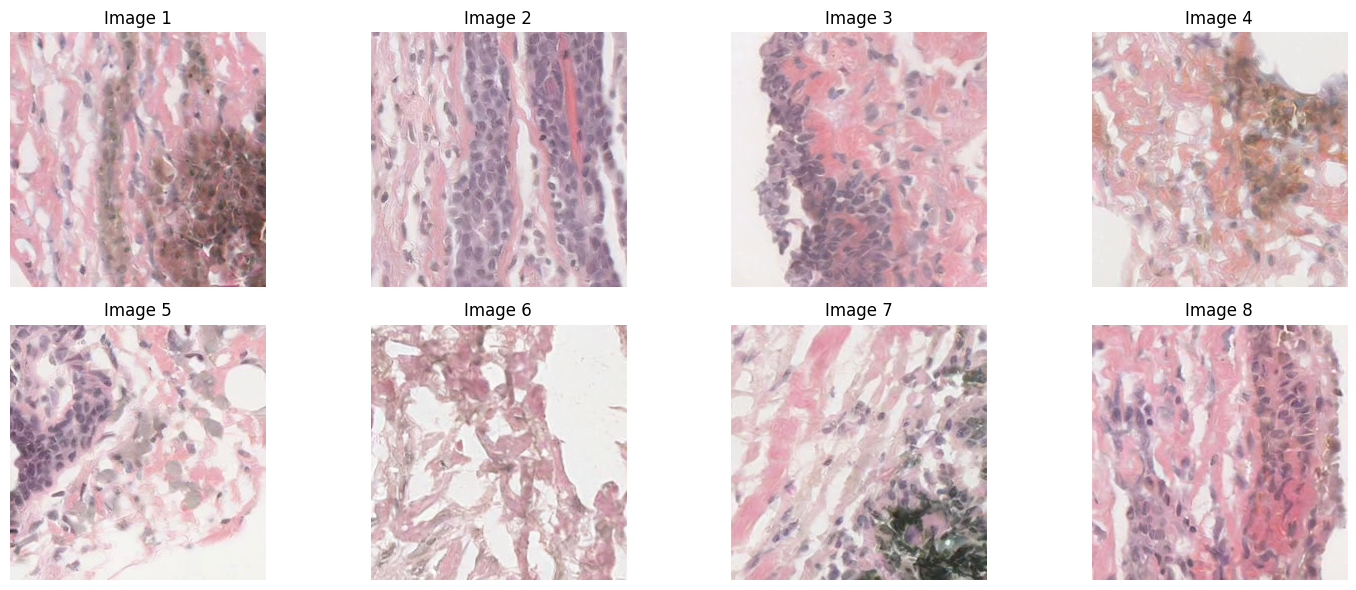

In [ ]:
image_plot("/content/Large-Image-Diffusion/brca20x_embeddings/fake_images/")

#### Corresponding real images

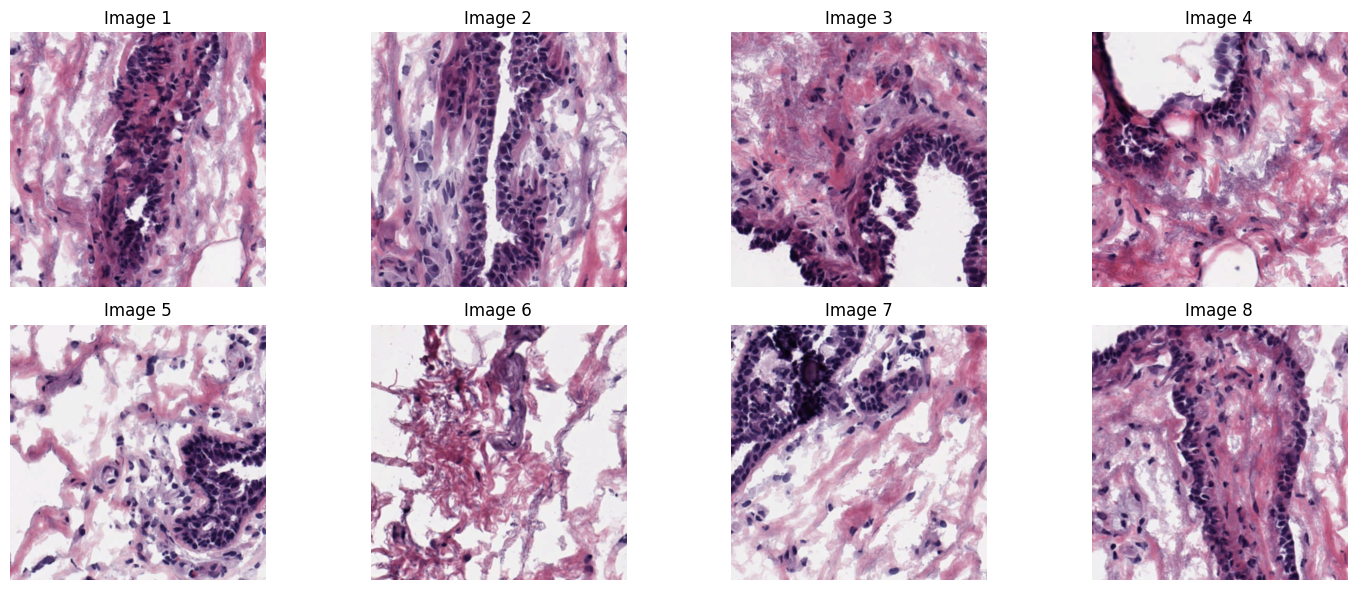

In [ ]:
image_plot("/content/Large-Image-Diffusion/brca20x_embeddings/real_images/")

### Generated images for CRC dataset

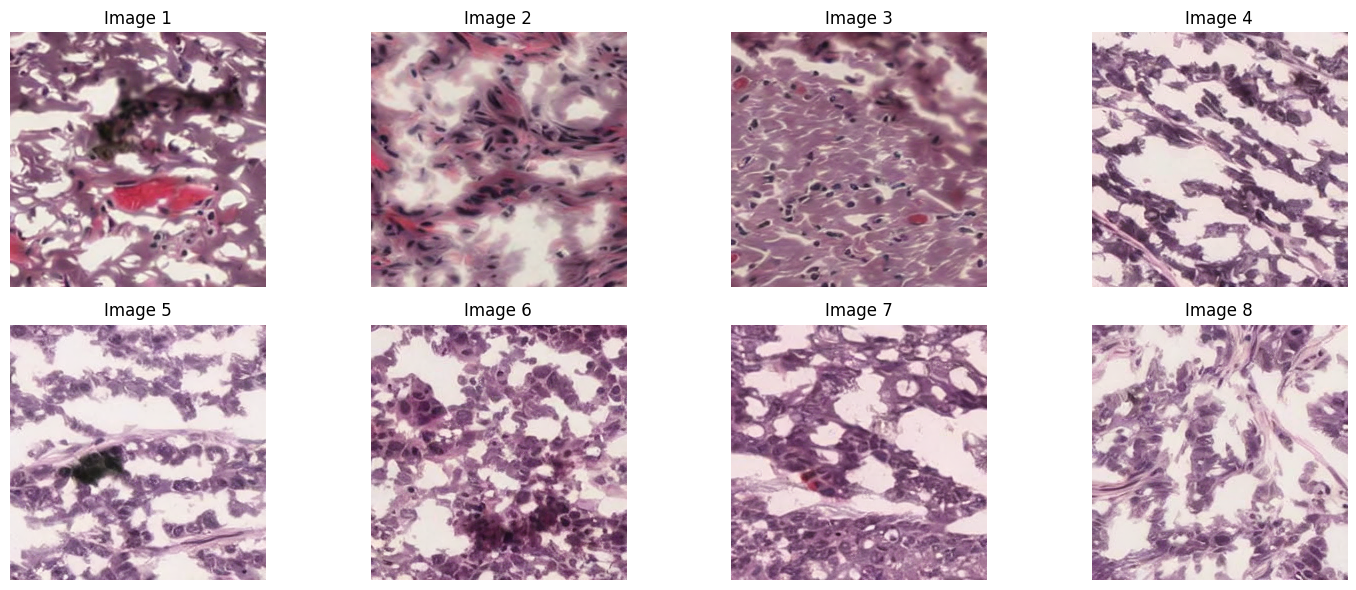

In [ ]:
image_plot("/content/Large-Image-Diffusion/crc_ibot_embeddings/fake_images/")

#### Corresponding real images

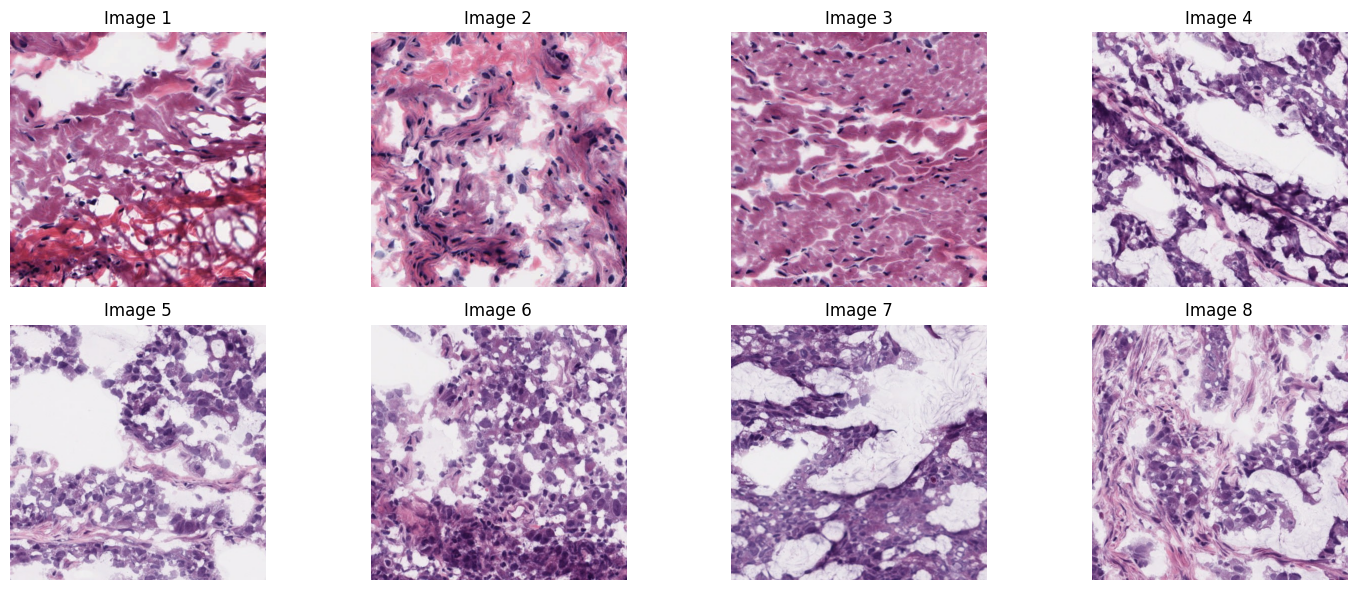

In [ ]:
image_plot("/content/Large-Image-Diffusion/crc_ibot_embeddings/real_images/")

### Generated Images for BRCA 5x dataset

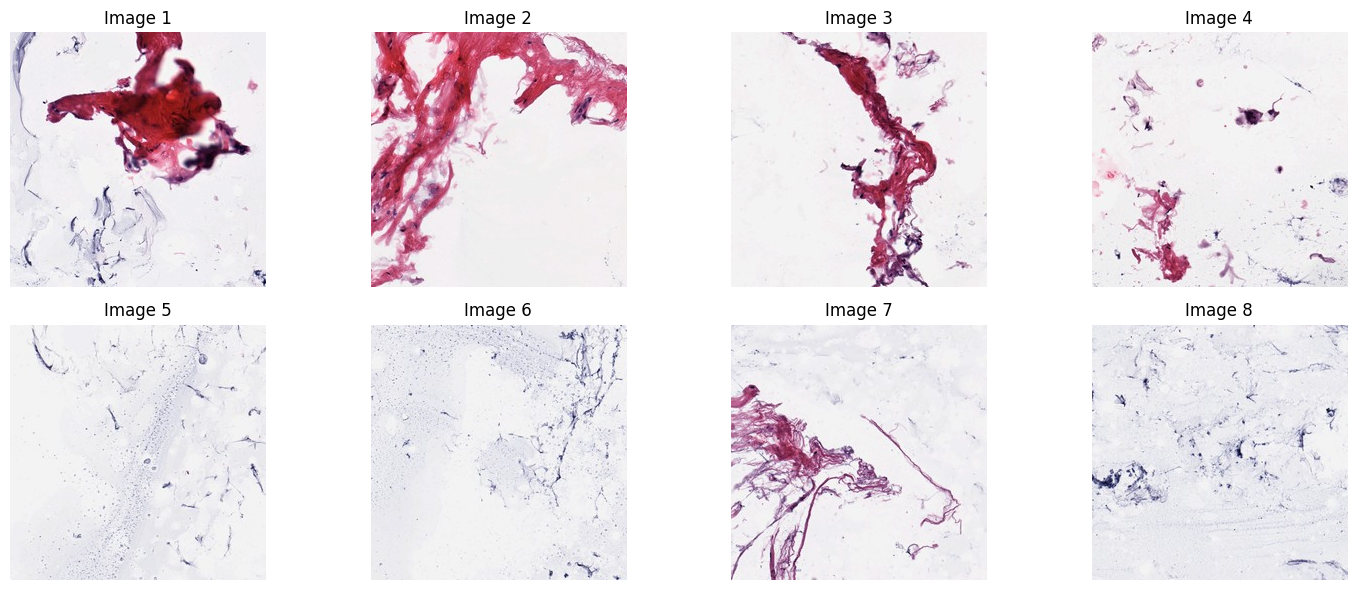

In [ ]:
image_plot("/content/Large-Image-Diffusion/brca5x_embeddings (1)/real_images/")

#### Corresponding real images

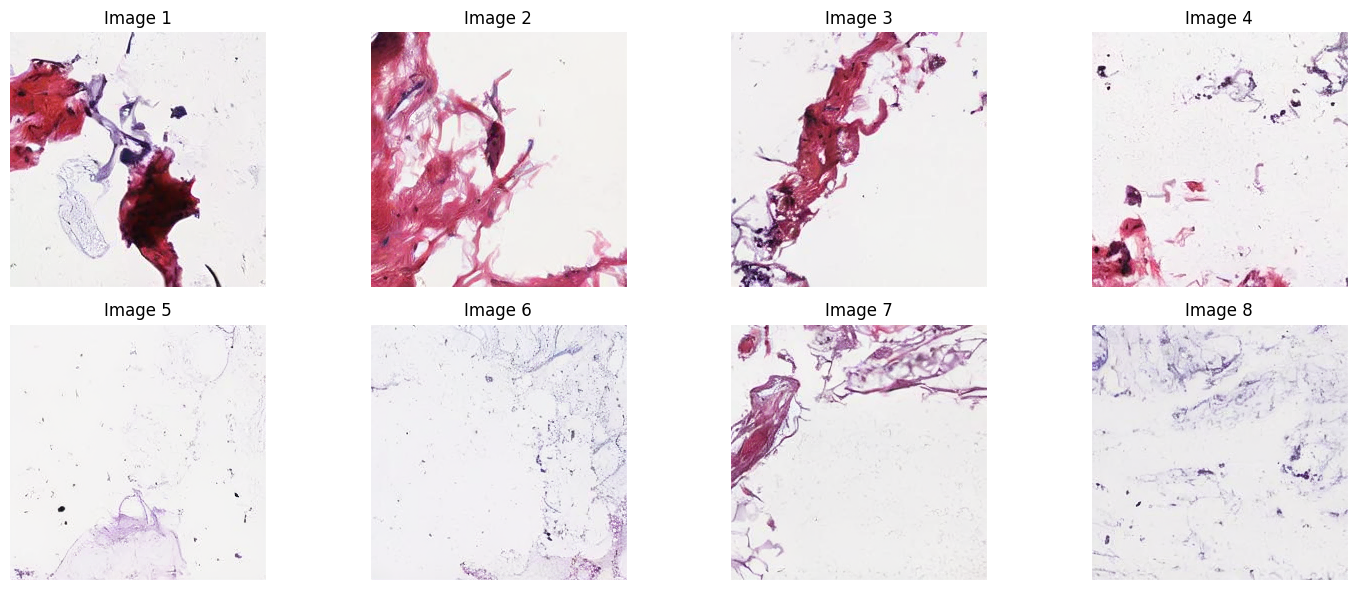

In [ ]:
image_plot("/content/Large-Image-Diffusion/brca5x_embeddings (1)/fake_images/")

# Result and analysis
The reproduced results show deviations in Fréchet Inception Distance (FID) scores due to differences in the datasets used. While the original paper reports FIDs in the range of 6–10, the reproduced scores were in the range of 60–80. This discrepancy stems from using a smaller subset (2k samples) instead of the larger dataset (8–15M samples) used in the original computations.

On further analysis it was found that the fids were originally computed on the Synthsised data verses a precoumpted fid_stats (presumably generated on the entire training dataset). FID scores are highly sensitive to dataset size, which likely introduced this variation. Despite the differences, the reproduced results remain consistent in trend and demonstrate the model's capacity to generate realistic and contextually accurate images, validating the robustness of the proposed approach. This can further be verified visually by the Generated images matching considerably with the data used.

|Data|Patch FID Score|
| --- | --- |
|Sample BRCA 20x|112.2|
|BRCA 20x|75.08|
|CRC 20x|61.36|
|BRCA 5x|79.22|

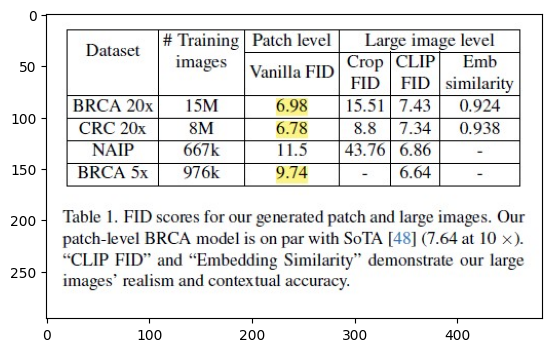

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

img = mpimg.imread('/content/LIG_comp_table.jpg')
imgplot = plt.imshow(img)
plt.show()

# Conclusion
The paper excels in innovation, scalability, and versatility, providing a practical solution for generating high-quality images. The patch-based framework ensures semantic and spatial consistency across large images while being flexible enough to extend to text-to-image synthesis. Future work could focus on optimizing for real-world applications, improving text-to-image capabilities, and exploring multi-modal input integrations to further enhance the framework's potential.